In [207]:
import glob
import json
import os
import time
import copy
from pathlib import Path
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.optim import lr_scheduler
import torchvision
from torchvision import transforms, utils, datasets, models
from torch.utils.data import Dataset

from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

In [175]:
def load_dataset_elements(dataset_root):
    elements = []
    
    for image in glob.glob(os.path.join(dataset_root, "images", "IMG_*.jpeg")):
        image_name = os.path.basename(image)
        labels_name = image_name.replace("image", "labels")
        labels_name = "{}.json".format(os.path.splitext(labels_name)[0])
        
        with open(os.path.join(dataset_root, "labels", labels_name)) as labels_file:
            raw_labels = json.load(labels_file)
            labels = []
            
            for label in ("plastic bags", "plastic bottles", "other plastic"):
                labels.append(1 if raw_labels[label] else 0)
                           
        elements.append((Image.open(image), labels))
                    
    return elements

In [176]:
class_names = ('plastic bags', 'plastic bottles', 'other plastic')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
if device == 'cpu':
    print(device)
else:
    print(torch.cuda.get_device_name())
    print(torch.__version__)
    print(torch.version.cuda)

NVIDIA GeForce GTX 1060
1.2.0
10.0


In [188]:
dataset = load_dataset_elements('Datasets')

batch_size = 4
workers = 0

np.random.shuffle(dataset)
training_dataset, test_dataset = dataset[8:], dataset[:8]
print(len(training))
print(len(test))

print(len(data))

32
8
40


In [178]:
class MyDataset(Dataset):
  def __init__(self, data):#self, image_tensors, labels):
    data_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    images = []
    labels = []
    for img, label in data:
        images.append(data_transforms(img))
        labels.append(label)
    #self.X = torch.tensor(imgs, dtype=torch.float32)
    self.X = images
    self.y = labels
    print(len(self.X))
    
  def __getitem__(self,idx):
    data = self.X[idx]
    #data = self.X.iloc[idx.item()]
    label = torch.tensor(self.y[idx], dtype=torch.float32)
    

    #if self.y is not None:
      #  return (data, self.y[i])
    #else:
    
    return data, label
  
  def __len__(self):
    return len(self.X)

In [192]:
training_data = MyDataset(training_dataset)
validate_data = MyDataset(test_dataset)
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, 
                                               shuffle=True, num_workers=workers)
val_dataloader = torch.utils.data.DataLoader(validate_data, batch_size=batch_size, 
                                               shuffle=True, num_workers=workers)

32
8


4


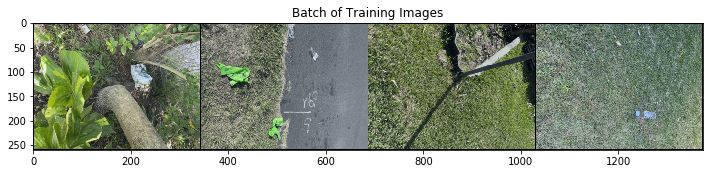

In [193]:
imgs, labs = next(iter(train_dataloader))
print(len(imgs))
plt.figure(figsize=(12,12))
#plt.axis("off")
plt.title("Batch of Training Images")
plt.imshow(np.transpose(utils.make_grid(imgs.to(device), padding=2, normalize=True).cpu(),(1,2,0)))

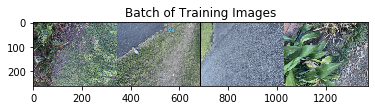

NameError: name 'how_many_to_plot' is not defined

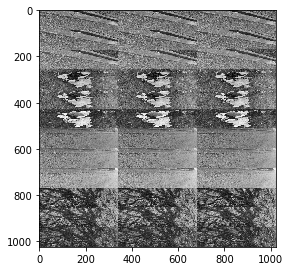

In [195]:

#print(f"Training set length: {len(dataset_train)} - Test set length {len(dataset_test)}")
#dataloader = {"train": train_dataloader, #DataLoader(trainset , shuffle=True , batch_size=batch_size),
              #"val": test_dataloader} #DataLoader(valset , shuffle=True , batch_size=batch_size)}

In [209]:
model = models.resnet50(pretrained=True) # load the pretrained model
num_features = model.fc.in_features # get the no of on_features in last Linear unit
model.to(device)
print(num_features)

2048


In [197]:
# this function is used during training process, to calculation the loss and accuracy
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [204]:
total_loss_train, total_acc_train = [],[]
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    
    curr_iter = (epoch - 1) * len(train_loader)
    
    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)
        # print('image shape:',images.size(0), 'label shape',labels.size(0))
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        curr_iter += 1
        
        if (i + 1) % 100 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)
            
    return train_loss.avg, train_acc.avg

In [205]:
def validate(val_loader, model, criterion, optimizer, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            N = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)

            val_loss.update(criterion(outputs, labels).item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg

In [210]:
epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]

for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_dataloader, model, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_dataloader, model, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

RuntimeError: Expected object of scalar type Long but got scalar type Float for argument #2 'target'

In [225]:
#load model and define number of classes
#model = EfficientNet.from_pretrained('efficientnet-b7', num_classes=5)

#Defining Optimizer and Loss Criteria
criterion = nn.CrossEntropyLoss()
learning_rate=1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model.to(device)

epochs = 10

#Trainer 

for epoch in range(epochs):  
    running_loss = 0.0 #loss
    correct=0 #num_correct in a batch
    total=0 #total_size

    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
       
        inputs, labels = inputs.to(device), labels.to(device)
        #labels = np.eye(labels)
        
        #calc loss
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, torch.max(labels, 1)[1])
        _, predicted = torch.max(outputs, 1)
        _, labels = torch.max(labels, 1)
        
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        accuracy = float(correct) / float(total)

        #backward prop
        loss.backward()
        optimizer.step()
        
    print(accuracy, loss)
    

0.625 tensor(0.0974, device='cuda:0', grad_fn=<NllLossBackward>)
0.8125 tensor(0.0108, device='cuda:0', grad_fn=<NllLossBackward>)
0.90625 tensor(1.5018, device='cuda:0', grad_fn=<NllLossBackward>)
0.875 tensor(0.2708, device='cuda:0', grad_fn=<NllLossBackward>)
0.90625 tensor(0.1282, device='cuda:0', grad_fn=<NllLossBackward>)
0.90625 tensor(0.0956, device='cuda:0', grad_fn=<NllLossBackward>)
0.875 tensor(0.0344, device='cuda:0', grad_fn=<NllLossBackward>)
0.90625 tensor(0.0391, device='cuda:0', grad_fn=<NllLossBackward>)
0.9375 tensor(0.0943, device='cuda:0', grad_fn=<NllLossBackward>)
0.9375 tensor(0.0348, device='cuda:0', grad_fn=<NllLossBackward>)


In [226]:
test_image , test_label = next(iter(train_dataloader))
test_image = image.to(device)
test_label = label.to(device)
output = 0
with torch.no_grad():
  output = model(test_image)
  output = torch.sigmoid(output)
output = output>0.2

IndexError: boolean index did not match indexed array along dimension 0; dimension is 3 but corresponding boolean dimension is 1000

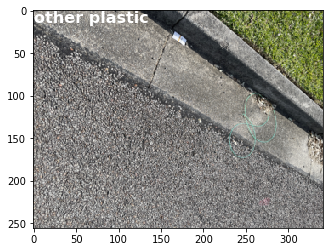

In [233]:
mean , std = torch.tensor([0.485, 0.456, 0.406]),torch.tensor([0.229, 0.224, 0.225])
def denormalize(image):
  image = image.to("cpu").clone().detach()
  image = transforms.Normalize(-mean/std,1/std)(image) #denormalize
  image = image.permute(1,2,0) 
  image = torch.clamp(image,0,1)
  return image.numpy()

def visualize(image , actual , pred, index):
    fig,ax = plt.subplots()
    ax.imshow(denormalize(image))
    ax.grid(False)
    classes =  np.array(class_names)[np.array(actual,dtype=np.bool)]
    for i , s in enumerate(classes):
        ax.text(0 , i*20  , s , verticalalignment='top', color="white", fontsize=16, weight='bold')
  
    classes =  np.array(class_names)[np.array(pred,dtype=np.bool)]
    for i , s in enumerate(classes):
        ax.text(160 , i*20  , s , verticalalignment='top', color="orange", fontsize=16, weight='bold')

    fig.savefig('Pics/output'+str(index)+'.png')
    
    plt.show()

#for i in range(len(test_image)):
visualize(test_image[0] , test_label[0].tolist() , output[0].tolist(), 0)

In [228]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    images_handeled = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                plt.imshow(inputs.cpu().data[j])

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

TypeError: Invalid shape (3, 256, 341) for image data

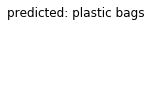

In [229]:
#base_model = train_model(model, criterion, optimiser, exp_lr_scheduler, num_epochs=3)
visualize_model(model)
plt.show()